In [ ]:
!pip install mne pyedflib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 49.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 66.0 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
import os
import numpy as np
import pandas as pd
import mne
from glob import glob
from scipy.signal import welch
from scipy.stats import zscore
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns
import pyedflib  # Для записи EDF с аннотациями

In [ ]:
# Монтирование Google Диска
drive.mount('/content/drive')

# Путь для извлечения
output_path = '/content/drive/My Drive/rats/rats_extracted/'

# Просмотр содержимого директории
!ls "{output_path}"

In [ ]:
# Шаг 1: Подготовка данных

def load_data(file_paths):
    """
    Загрузка EDF-файлов и извлечение сигналов и аннотаций.
    """
    data = []
    annotations = []
    raws = []
    for file_path in file_paths:
        raw = mne.io.read_raw_edf(file_path, preload=True, verbose=False)
        data.append(raw.get_data())
        annots = raw.annotations
        annotations.append(annots)
        raws.append(raw)
    return data, annotations, raws

def process_annotations(annotations_list, durations):
    labels_list = []
    for annotations, duration in zip(annotations_list, durations):
        labels = []
        current_events = {}
        sorted_annotations = sorted(
            zip(annotations.onset, annotations.duration, annotations.description),
            key=lambda x: x[0]
        )

        for onset, ann_duration, desc in sorted_annotations:
            desc_lower = desc.lower()
            if desc_lower in ['swd1', 'ds1', 'is1']:
                label_type = desc_lower[:-1].upper()  # SWD, DS, IS
                if label_type in current_events:
                    print(f"Предупреждение: Событие {label_type} уже начато на {current_events[label_type]}. Пропуск нового начала.")
                else:
                    current_events[label_type] = onset
            elif desc_lower in ['swd2', 'ds2', 'is2']:
                label_type = desc_lower[:-1].upper()
                if label_type in current_events:
                    event_start = current_events.pop(label_type)
                    event_end = onset
                    event_duration = event_end - event_start
                    if event_duration > 0:
                        labels.append((event_start, event_duration, label_type))
                    else:
                        print(f"Предупреждение: Некорректная длительность события {label_type} от {event_start} до {event_end}. Пропуск.")
                else:
                    print(f"Предупреждение: Завершение события {label_type} на момент {onset}, но нет открытого события.")
            else:
                print(f"Предупреждение: Неизвестный тип аннотации '{desc}' на момент {onset}. Пропуск.")

        # Проверка на незавершённые события
        for label_type, event_start in current_events.items():
            event_duration = duration - event_start
            if event_duration > 0:
                labels.append((event_start, event_duration, label_type))
            else:
                print(f"Предупреждение: Некорректная длительность события {label_type} от {event_start} до конца записи. Пропуск.")

        labels_list.append(labels)
    return labels_list




In [ ]:
# Пути к директориям с данными
fully_marked_files = glob(os.path.join(output_path, 'ECoG_fully_marked', '*_fully_marked.edf'))
golden_standard_files = glob(os.path.join(output_path, 'ECoG_golden_standard', '*_edited.edf'))
unmarked_files = glob(os.path.join(output_path, 'ECoG_unmarked', '*.edf'))

print(f"Полностью размеченные файлы: {len(fully_marked_files)}")
print(f"Золотой стандарт файлов: {len(golden_standard_files)}")
print(f"Неразмеченные файлы: {len(unmarked_files)}")

In [ ]:
# Загрузка данных и аннотаций для размеченных файлов (используются для обучения)
fully_marked_data, fully_marked_annotations, fully_marked_raws = load_data(fully_marked_files)
golden_standard_data, golden_standard_annotations, golden_standard_raws = load_data(golden_standard_files)

# Получение частоты дискретизации и длительности записи из данных
sfreq = fully_marked_raws[0].info['sfreq']
durations = [raw.times[-1] for raw in fully_marked_raws]  # Длительность каждого файла в секундах
print(f"Частота дискретизации: {sfreq} Гц")

In [ ]:
# Обработка аннотаций с учётом фактической длительности записи
fully_marked_labels = process_annotations(fully_marked_annotations, durations)

In [ ]:
# Шаг 2: Предобработка данных

def bandpass_filter(data, l_freq=0.5, h_freq=100, sfreq=400):
    """
    Применение полосового фильтра к данным с использованием IIR-фильтра.
    """
    iir_params = dict(order=4, ftype='butter')
    filtered_data = mne.filter.filter_data(
        data, sfreq, l_freq, h_freq, method='iir', iir_params=iir_params, verbose=False)
    return filtered_data

def segment_signal(data, labels, window_size=5, overlap=0.5, sfreq=400):
    """
    Сегментация сигнала на окна и присвоение меток.
    """
    segments = []
    segment_labels = []
    step = int(window_size * sfreq * (1 - overlap))
    window_samples = int(window_size * sfreq)
    total_samples = data.shape[1]
    num_windows = (total_samples - window_samples) // step + 1

    for w in range(num_windows):
        start = w * step
        end = start + window_samples
        segment = data[:, start:end]
        if segment.shape[1] < window_samples:
            continue  # Пропускаем сегменты, которые меньше заданного размера окна
        segments.append(segment)
        # Определяем метку для сегмента
        segment_time = start / sfreq
        label = 'Unknown'
        for onset, duration, desc in labels:
            if onset <= segment_time < onset + duration:
                label = desc
                break
        segment_labels.append(label)
    return segments, segment_labels

def normalize_segments(segments):
    """
    Нормализация каждого сегмента.
    """
    normalized_segments = []
    for segment in segments:
        normalized = zscore(segment, axis=1)
        normalized_segments.append(normalized)
    return normalized_segments

In [ ]:
# Фильтрация данных
filtered_data = []
for data in fully_marked_data:
    filtered = bandpass_filter(data, l_freq=0.5, h_freq=100, sfreq=sfreq)
    filtered_data.append(filtered)

# Сегментация и присвоение меток
segments = []
segment_labels = []
for data, labels in zip(filtered_data, fully_marked_labels):
    segs, seg_labels = segment_signal(data, labels, window_size=5, overlap=0.5, sfreq=sfreq)
    segments.extend(segs)
    segment_labels.extend(seg_labels)

# Нормализация сегментов
normalized_segments = normalize_segments(segments)

# Удаление сегментов с меткой 'Unknown'
known_indices = [i for i, label in enumerate(segment_labels) if label != 'Unknown']
normalized_segments = [normalized_segments[i] for i in known_indices]
segment_labels = [segment_labels[i] for i in known_indices]

In [ ]:
# Шаг 3: Подготовка данных для модели

# Удаляем суффиксы '1' и '2' из меток
processed_labels = [label.rstrip('12') for label in segment_labels]

# Кодирование меток
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(processed_labels)
print("Классы:", label_encoder.classes_)

# Преобразование списка сегментов в массив NumPy
X = np.array([seg.T for seg in normalized_segments])  # Форма: (samples, timesteps, features)
y = encoded_labels

print(f"Форма X: {X.shape}")  # Должно быть (samples, timesteps, features)

Классы: ['DS' 'IS' 'SWD']
Форма X: (18979, 2000, 3)


In [ ]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split

In [ ]:
# Шаг 4: Построение модели нейронной сети на основе LSTM

def build_lstm_model(input_shape, num_classes):
#    """
#    Построение модели на основе LSTM.
#    """
#    model = Sequential()
#    # Первый LSTM слой с возвратом последовательностей для следующего LSTM слоя
#    model.add(Bidirectional(LSTM(128, return_sequences=True), input_shape=input_shape))
#    model.add(Dropout(0.5))
#    # Второй LSTM слой без возврата последовательностей
#    model.add(Bidirectional(LSTM(64)))
#    model.add(Dropout(0.5))
#    # Полносвязный слой
#    model.add(Dense(256, activation='relu'))
#    model.add(Dropout(0.5))
#    # Выходной слой с softmax для классификации
#    model.add(Dense(num_classes, activation='softmax'))
#    # Компиляция модели
#    model.compile(loss='sparse_categorical_crossentropy',
#                  optimizer='adam', metrics=['accuracy'])
#    return model

    """
    Построение модели на основе LSTM с оптимизациями для ускорения обучения.
    """
    model = Sequential()
    # Первый LSTM слой с использованием Input слоя
    model.add(Input(shape=input_shape))
    model.add(LSTM(64, return_sequences=True))  # Уменьшено количество нейронов 64
    model.add(Dropout(0.3))  # Уменьшен dropout для ускорения
    model.add(LSTM(32))  # Уменьшено количество нейронов 32
    model.add(Dropout(0.3))  # Уменьшен dropout для ускорения
    # Полносвязный слой
    model.add(Dense(128, activation='relu')) #128
    model.add(Dropout(0.3))
    # Выходной слой с softmax для классификации
    model.add(Dense(num_classes, activation='softmax'))
    # Компиляция модели
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer='adam', metrics=['accuracy'])
    return model

# Разделение данных на обучающую и валидационную выборки
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Построение модели
input_shape = (X.shape[1], X.shape[2])  # (timesteps, features)
num_classes = len(label_encoder.classes_)
model = build_lstm_model(input_shape, num_classes)

# Коллбэки
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Обучение модели
history = model.fit(
    X_train, y_train,
    epochs=50,  # Уменьшено количество эпох было 50 30
    batch_size=32,  # Уменьшен размер батча было 32 16
    validation_data=(X_val, y_val),
    callbacks=[early_stopping]
)


Epoch 1/5
238/238 ━━━━━━━━━━━━━━━━━━━━ 34s 120ms/step - accuracy: 0.7957 - loss: 0.6559 - val_accuracy: 0.8901 - val_loss: 0.4125
Epoch 2/5
238/238 ━━━━━━━━━━━━━━━━━━━━ 37s 117ms/step - accuracy: 0.8883 - loss: 0.4332 - val_accuracy: 0.8901 - val_loss: 0.4658
Epoch 3/5
238/238 ━━━━━━━━━━━━━━━━━━━━ 41s 116ms/step - accuracy: 0.8934 - loss: 0.4057 - val_accuracy: 0.8901 - val_loss: 0.4671
Epoch 4/5
238/238 ━━━━━━━━━━━━━━━━━━━━ 41s 118ms/step - accuracy: 0.8914 - loss: 0.4413 - val_accuracy: 0.8909 - val_loss: 0.4067
Epoch 5/5
238/238 ━━━━━━━━━━━━━━━━━━━━ 41s 116ms/step - accuracy: 0.8948 - loss: 0.3903 - val_accuracy: 0.8901 - val_loss: 0.4074


119/119 [==============================] - 37s 304ms/step - loss: 1.2885 - accuracy: 0.4642
Точность на валидационных данных: 46.42%
119/119 [==============================] - 36s 303ms/step
              precision    recall  f1-score   support

          DS       0.89      0.49      0.64      3379
          IS       0.08      0.02      0.04       226
         SWD       0.05      0.45      0.08       191

    accuracy                           0.46      3796
   macro avg       0.34      0.32      0.25      3796
weighted avg       0.80      0.46      0.57      3796



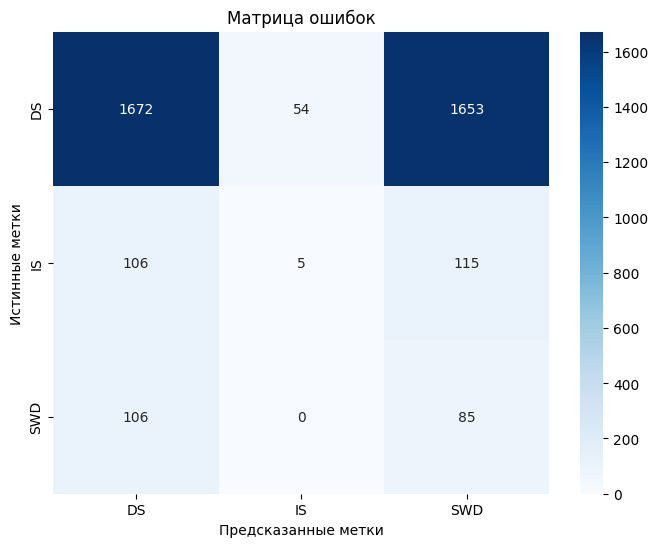

In [ ]:
# Шаг 5: Оценка модели

# Оценка на валидационных данных
val_loss, val_accuracy = model.evaluate(X_val, y_val)
print(f'Точность на валидационных данных: {val_accuracy * 100:.2f}%')

# Отчет о классификации
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)
print(classification_report(y_val, y_pred_classes, target_names=label_encoder.classes_, zero_division=0))

# Матрица ошибок
cm = confusion_matrix(y_val, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_, cmap='Blues')
plt.xlabel('Предсказанные метки')
plt.ylabel('Истинные метки')
plt.title('Матрица ошибок')
plt.show()

In [ ]:
# Шаг 6: Применение модели к неразмеченным данным и сохранение аннотаций в EDF

def predict_unmarked_data(model, file_paths, sfreq=400):
    """
    Предсказание меток для неразмеченных данных.
    """
    predictions = {}
    durations = {}
    for file_path in file_paths:
        raw = mne.io.read_raw_edf(file_path, preload=True, verbose=False)
        data = raw.get_data()
        duration = raw.times[-1]  # Длительность записи в секундах
        durations[file_path] = duration
        filtered = bandpass_filter(data, l_freq=0.5, h_freq=100, sfreq=sfreq)
        segments, _ = segment_signal(filtered, [], window_size=5, overlap=0.5, sfreq=sfreq)
        normalized_segments = normalize_segments(segments)
        X_unmarked = np.array([seg.T for seg in normalized_segments])
        # Проверка на наличие сегментов
        if X_unmarked.size == 0:
            print(f"Файл {file_path} не содержит подходящих сегментов для предсказания.")
            predictions[file_path] = []
            continue
        preds = model.predict(X_unmarked)
        pred_classes = np.argmax(preds, axis=1)
        pred_labels = label_encoder.inverse_transform(pred_classes)
        predictions[file_path] = pred_labels
    return predictions, durations

# Предсказание на неразмеченных данных
unmarked_predictions, unmarked_durations = predict_unmarked_data(model, unmarked_files, sfreq=sfreq)
for file_path, preds in unmarked_predictions.items():
    unique_labels, counts = np.unique(preds, return_counts=True)
    print(f"Файл: {file_path}, Предсказанные метки: {dict(zip(unique_labels, counts))}")


270/270 [==============================] - 226s 837ms/step
Файл: /content/drive/My Drive/rats/rats_extracted/ECoG_unmarked/Ati4x1_15m_BL_6h.edf, Предсказанные метки: {'DS': 8639}
Файл: /content/drive/My Drive/rats/rats_extracted/ECoG_unmarked/Ati4x1_15m_BL_6h_annotated_annotated.edf, Предсказанные метки: {'DS': 8639}
Файл: /content/drive/My Drive/rats/rats_extracted/ECoG_unmarked/Ati4x1_15m_BL_6h_annotated.edf, Предсказанные метки: {'DS': 8639}


In [ ]:
# Функция для добавления аннотаций в EDF-файл
def add_annotations_to_edf(original_edf, annotations, output_edf):
    import pyedflib

    # Чтение исходного EDF
    f = pyedflib.EdfReader(original_edf)
    n_channels = f.signals_in_file
    signal_headers = f.getSignalHeaders()
    data = [f.readSignal(i) for i in range(n_channels)]
    f.close()

    # Создание нового EDF-файла
    writer = pyedflib.EdfWriter(output_edf, n_channels=n_channels, file_type=pyedflib.FILETYPE_EDFPLUS)

    # Установка заголовков
    writer.setSignalHeaders(signal_headers)

    # Запись сигналов
    writer.writeSamples(data)

    # Добавление аннотаций
    for onset, duration, label in annotations:
        # Добавляем начало события
        writer.writeAnnotation(onset, 0.0, label.lower() + '1')
        # Добавляем конец события
        writer.writeAnnotation(onset + duration, 0.0, label.lower() + '2')

    # Закрытие файла
    writer.close()

In [ ]:
# Создание аннотаций для неразмеченных файлов и сохранение EDF
for file_path, preds in unmarked_predictions.items():
    duration = unmarked_durations[file_path]
    annotations = []
    current_events = {}
    for i, label in enumerate(preds):
        window_start_time = i * 2.5  # Шаг окна
        window_end_time = window_start_time + 5  # Размер окна

        if label != 'Unknown':
            if label in current_events:
                # Расширяем текущее событие, если оно продолжается
                current_events[label]['end'] = window_end_time
                print(f"Расширение события {label}: {current_events[label]['start']} до {current_events[label]['end']}")
            else:
                # Начинаем новое событие
                current_events[label] = {'start': window_start_time, 'end': window_end_time}
                print(f"Начало нового события {label}: {current_events[label]['start']} до {current_events[label]['end']}")
        else:
            # Если текущий лейбл 'Unknown', завершаем все открытые события
            for lbl in list(current_events.keys()):
                event = current_events.pop(lbl)
                event_duration = event['end'] - event['start']
                if event_duration > 0:
                    annotations.append((event['start'], event_duration, lbl))
                    print(f"Завершение события {lbl}: {event['start']} до {event['end']}, длительность {event_duration}")

    # Завершаем все оставшиеся события после цикла
    for label, event in current_events.items():
        event_duration = event['end'] - event['start']
        if event_duration > 0:
            annotations.append((event['start'], event_duration, label))
            print(f"Завершение события {label}: {event['start']} до {event['end']}, длительность {event_duration}")
        else:
            print(f"Предупреждение: Некорректная длительность события {label} от {event['start']} до {event['end']}. Пропуск.")

    # Сохраняем аннотации в EDF
    output_file = os.path.splitext(file_path)[0] + '_annotated.edf'
    add_annotations_to_edf(file_path, annotations, output_file)
    print(f"Аннотации добавлены и сохранены в {output_file}")


Выходные данные были обрезаны до нескольких последних строк (5000).
Расширение события SWD: 0.0 до 9112.5
Расширение события SWD: 0.0 до 9115.0
Расширение события SWD: 0.0 до 9117.5
Расширение события SWD: 0.0 до 9120.0
Расширение события DS: 2.5 до 9122.5
Расширение события SWD: 0.0 до 9125.0
Расширение события SWD: 0.0 до 9127.5
Расширение события SWD: 0.0 до 9130.0
Расширение события DS: 2.5 до 9132.5
Расширение события DS: 2.5 до 9135.0
Расширение события SWD: 0.0 до 9137.5
Расширение события SWD: 0.0 до 9140.0
Расширение события SWD: 0.0 до 9142.5
Расширение события DS: 2.5 до 9145.0
Расширение события DS: 2.5 до 9147.5
Расширение события DS: 2.5 до 9150.0
Расширение события SWD: 0.0 до 9152.5
Расширение события DS: 2.5 до 9155.0
Расширение события DS: 2.5 до 9157.5
Расширение события SWD: 0.0 до 9160.0
Расширение события DS: 2.5 до 9162.5
Расширение события DS: 2.5 до 9165.0
Расширение события SWD: 0.0 до 9167.5
Расширение события SWD: 0.0 до 9170.0
Расширение события DS: 2.5 до 

In [ ]:
# Шаг 7: Сохранение модели

# Сохранение модели
model.save('ecog_classification_model_lstm_optimized.h5')
print("Модель сохранена как 'ecog_classification_model_lstm_optimized.h5'")

Модель сохранена как 'ecog_classification_model_lstm_optimized.h5'


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
from google.colab import files

files.download('ecog_classification_model_lstm_optimized.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>